In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from abcd_graph import ABCDGraph, ABCDParams
import csv
import subprocess
import sys
sys.path.append('../../')
from CAS import *


## ABCD-oo graphs

Main 2 files:

```
networkfile<xi>_<eta>_<rep>.txt : the edges, 1-based node ids, tab separated
communityfile<xi>_<eta>_<rep>.txt : node <tab> list of communities in [], for example:
1       [24]
2       [3, 28]
3       [10]
```


In [2]:
path = './Datasets/abcdoo_yt_'
def readGraph(xi=0.5, eta=1.5, n=5000):
    ## read edges, build graph
    fn = path+str(xi)+'_'+str(eta)+'_'+str(n)+'_edge.dat'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1 ## map to 0-based
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+str(xi)+'_'+str(eta)+'_'+str(n)+'_com.dat'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G
   

In [3]:
oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi'          ## overlapping NMI executable
#oNMI = '/work/home/fcthebe/Tools/oNMI/onmi'          ## overlapping NMI executable

## input format: 
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x


In [4]:
def memberships2list(S):
    L = []
    for i in range(len(S.indptr)-1):
        if S.indptr[i] == S.indptr[i+1]:
            L.append([0]) ## no membership == outlier (community 0)
        else:
            L.append(list(S.indices[S.indptr[i]:S.indptr[i+1]]+1)) ## 1-based
    return L

## given list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L

In [5]:
from itertools import combinations
def CPM(g, k=3):
    cls = list(map(set, g.cliques(min=k,max=k)))
    edgelist = []
    for i in range(len(cls)):
        edgelist.append((i,i))
    for i,j in combinations(range(len(cls)),2):
        if len(cls[i].intersection(cls[j])) >= (k-1):
            edgelist.append((i,j))
    cg = ig.Graph(edgelist, directed=False)
    clusters = cg.connected_components()
    L = []
    for cluster in clusters:
        members = set()
        for i in cluster:
            members.update(cls[i])
        L.append(set(g.vs[members]["name"]))
    return L


In [6]:
def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP or ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    #ctr = 1
    for nm in names:
#         if ctr%1000==0:
#             print(ctr)
#         ctr+=1
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32)
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


In [7]:
def Jaccard(a,b):
    x = len(set(a).intersection(set(b)))/len(set(a).union(set(b)))
    return x

def weightedLinegraph(g):
    lg = g.linegraph()
    w=[]
    for e in lg.es:
        A = set(g.es[e.tuple[0]].tuple)
        B = set(g.es[e.tuple[1]].tuple)
        x = list((A-B).union(B-A))
        w.append(Jaccard(g.neighbors(x[0]),g.neighbors(x[1])))
    lg.es['weight'] = w
    return lg

def edgeCluster(g, color=False):
    q = -999
    D = weightedLinegraph(g)
    for th in sorted(set(D.es['weight'])):
        ## filter edges w.r.t. similarity and find CC
        dg = D.copy()
        dg.delete_edges([e for e in dg.es if e['weight']<=th])
        cc = dg.connected_components().membership
        mod = D.modularity(cc)
        if mod>q:
            q = mod
            g.es['lc'] = cc
            if color:
                pal = ig.ClusterColoringPalette(n=max(cc)+1)
                for e in g.es:
                    e['color'] = pal[e['lc']]
    ## Now gather the nodes for each edge cluster
    L = []
    for i in range(max(g.es['lc'])+1):
        sg = g.subgraph_edges([e for e in g.es if e['lc']==i])
        L.append(sg.vs['name'])
    return L

## Quick test

In [8]:
xi = 0.10
eta = 1.0
# xi = 0.3
# eta = 1.1
G = readGraph(xi=xi,eta=eta)
G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
GT = mems2comms(G.vs['comms'])[1:]  ## no "outlier community"
GT = [[str(i) for i in x] for x in GT]

In [9]:
%%time
CP = CPM(G)


CPU times: user 1min 42s, sys: 264 ms, total: 1min 42s
Wall time: 1min 42s


In [10]:
%%time
G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
LD = mems2comms([[x] for x in G.vs['leiden']])
LD = [[str(i) for i in j] for j in LD]


CPU times: user 10.4 ms, sys: 696 μs, total: 11.1 ms
Wall time: 11.1 ms


In [11]:
%%time
comms_es = EgoSplit(G, split='CC', algo='ECG')
ES = [list(x) for x in comms_es if len(x)>=10]


CPU times: user 59.1 s, sys: 966 ms, total: 1min
Wall time: 1min


In [12]:
%%time
C = sparse.csc_matrix((G.vcount(),len(ES)))
C.indices = np.array([int(i) for j in ES for i in j])
C.data = np.repeat(1,len(C.indices))
ptr = [0]
ctr = 0
for x in ES:
    ctr += len(x)
    ptr.append(ctr)
C.indptr = np.array(ptr)
M = C.tocsr()
## Beta
IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M)
L = []
th = 0.25
for i in range(IEF.shape[1]):
    x = np.where( (np.array(IEF[:,i].todense()).flatten() >= th))[0]
    if len(x)>0:
        L.append(list(x))        

CPU times: user 367 ms, sys: 10.7 ms, total: 378 ms
Wall time: 369 ms


In [13]:
compute_oNMI(L,ES)

0.937114

In [14]:
X = [eta, compute_oNMI( CP, GT ), compute_oNMI( LD, GT ), compute_oNMI( ES, GT ), compute_oNMI(GT, L), xi]
print(X)


[1.0, 0.907846, 0.992493, 0.937312, 0.999366, 0.1]


In [15]:
%%time
EC = edgeCluster(G)
_EC = [x for x in EC if len(x) >= 10]
compute_oNMI(_EC,GT)


CPU times: user 4min 9s, sys: 7.66 s, total: 4min 17s
Wall time: 4min 20s


0.814815

## Compare algorithms: CPM, Leiden, Ego-Split, ES+Beta, Edge clustering


In [16]:
Results = []
for xi in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    for eta in [1.0,1.25,1.5,1.75,2.0,2.25,2.5]:
        G = readGraph(xi=xi, eta=eta, n=5000)
        G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
        GT = mems2comms(G.vs['comms'])[1:]  ## ignore "outlier community"
        GT = [[str(i) for i in x] for x in GT]
        CP = CPM(G)
        G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
        LD = mems2comms([[x] for x in G.vs['leiden']])
        LD = [[str(i) for i in j] for j in LD]
        comms_es = EgoSplit(G, split='CC', algo='ECG')
        ES = [list(x) for x in comms_es if len(x)>=10]
        C = sparse.csc_matrix((G.vcount(),len(ES)))
        C.indices = np.array([int(i) for j in ES for i in j])
        C.data = np.repeat(1,len(C.indices))
        ptr = [0]
        ctr = 0
        for x in ES:
            ctr += len(x)
            ptr.append(ctr)
        C.indptr = np.array(ptr)
        M = C.tocsr()
        ## Beta
        IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M)
        L = []
        th = 0.2
        for i in range(Beta.shape[1]):
            x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th))[0]
            if len(x)>0:
                L.append(list(x)) 
        LL = []
        th = 0.25
        for i in range(IEF.shape[1]):
            x = np.where( (np.array(IEF[:,i].todense()).flatten() >= th))[0]
            if len(x)>0:
                LL.append(list(x)) 
        ## Edge clustering
        _EC = edgeCluster(G)
        EC = [x for x in _EC if len(x) >= 10]
        X = [eta, xi, compute_oNMI( CP, GT ), compute_oNMI( LD, GT ), compute_oNMI( ES, GT ), compute_oNMI(GT, L), 
             compute_oNMI(GT, LL),compute_oNMI(GT, EC)]
        print(eta, xi, X)
        Results.append(X)
        
df = pd.DataFrame(Results, columns=['eta','xi','cpm','leiden','ego','beta','ief','edge'])
with open('algo_compare_5000.pkl','wb') as fp:
    pickle.dump(df,fp)    

1.0 0.1 [1.0, 0.1, 0.907846, 0.992493, 0.937675, 0.998995, 0.999366, 0.814815]
1.25 0.1 [1.25, 0.1, 0.00492527, 0.244036, 0.419068, 0.544411, 0.540569, 0.0570535]
1.5 0.1 [1.5, 0.1, 0.00368762, 0.0866636, 0.148121, 0.251391, 0.255151, 0.0340334]
1.75 0.1 [1.75, 0.1, 0.00503565, 0.0973903, 0.064283, 0.148695, 0.152747, 0.00809767]
2.0 0.1 [2.0, 0.1, 0.00507797, 0.0994401, 0.0444856, 0.113115, 0.112735, 0.013593]
2.25 0.1 [2.25, 0.1, 0.00342788, 0.097494, 0.0410064, 0.0940962, 0.102766, 0.0100559]
2.5 0.1 [2.5, 0.1, 0.00435726, 0.0557493, 0.0288872, 0.0650306, 0.0649135, 0.00354034]
1.0 0.2 [1.0, 0.2, 0.780961, 0.949992, 0.833166, 0.986492, 0.986665, 0.62951]
1.25 0.2 [1.25, 0.2, 0.00835776, 0.22611, 0.297973, 0.460517, 0.457598, 0.0719699]
1.5 0.2 [1.5, 0.2, 0.00970171, 0.123388, 0.0962694, 0.222186, 0.208991, 0.0239007]
1.75 0.2 [1.75, 0.2, 0.00505154, 0.128896, 0.0730717, 0.153831, 0.150797, 0.0192255]
2.0 0.2 [2.0, 0.2, 0.00471485, 0.0809179, 0.0219703, 0.11667, 0.113268, 0.0214022]


In [17]:
with open('./algo_compare_5000.pkl','rb') as fp:
    df = pickle.load(fp)
df.columns = ['eta', 'xi', 'CPM', 'Leiden', 'EgoSplit', 'EgoSplit+Beta', 'EgoSplit+IEF','Edge']

In [18]:
df

,eta,xi,CPM,Leiden,EgoSplit,EgoSplit+Beta,EgoSplit+IEF,Edge
0,1.00,0.1,9.078460e-01,9.924930e-01,9.376750e-01,0.998995,9.993660e-01,0.814815
1,1.25,0.1,4.925270e-03,2.440360e-01,4.190680e-01,0.544411,5.405690e-01,0.057054
2,1.50,0.1,3.687620e-03,8.666360e-02,1.481210e-01,0.251391,2.551510e-01,0.034033
3,1.75,0.1,5.035650e-03,9.739030e-02,6.428300e-02,0.148695,1.527470e-01,0.008098
4,2.00,0.1,5.077970e-03,9.944010e-02,4.448560e-02,0.113115,1.127350e-01,0.013593
5,2.25,0.1,3.427880e-03,9.749400e-02,4.100640e-02,0.094096,1.027660e-01,0.010056
6,2.50,0.1,4.357260e-03,5.574930e-02,2.888720e-02,0.065031,6.491350e-02,0.003540
7,1.00,0.2,7.809610e-01,9.499920e-01,8.331660e-01,0.986492,9.866650e-01,0.629510
8,1.25,0.2,8.357760e-03,2.261100e-01,2.979730e-01,0.460517,4.575980e-01,0.071970
9,1.50,0.2,9.701710e-03,1.233880e-01,9.626940e-02,0.222186,2.089910e-01,0.023901


## Plots for WAW ABCD-oo paper

In [19]:
from matplotlib import colormaps
import matplotlib.colors as colors
cmap = colormaps.get_cmap('mako')
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = truncate_colormap(cmap,0,.85)


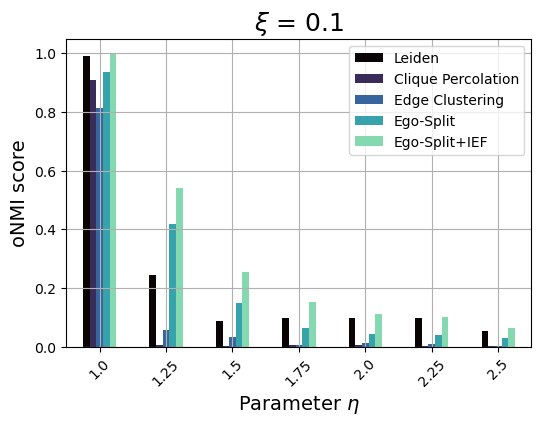

In [20]:
df[df.xi==.1].plot(x='eta',y=['Leiden', 'CPM', 'Edge', 'EgoSplit', 'EgoSplit+IEF'], 
                    kind='bar', figsize=(6,4), colormap=cmap)
plt.grid()
plt.legend(['Leiden','Clique Percolation','Edge Clustering','Ego-Split','Ego-Split+IEF'])
plt.xlabel(r'Parameter $\eta$', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('oNMI score', fontsize=14)
plt.title(r'$\xi$ = 0.1', fontsize=18)
plt.savefig('compare_algos_eta.png');


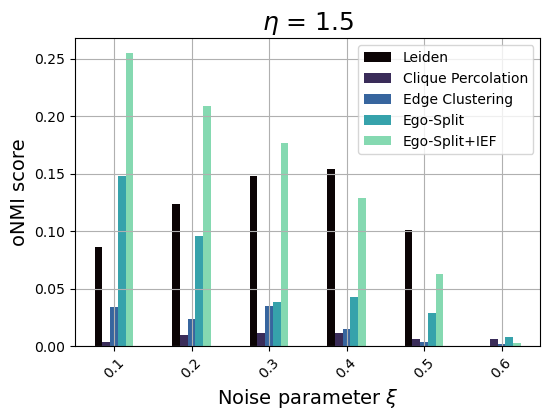

In [21]:
df[df.eta==1.5].plot(x='xi',y=['Leiden', 'CPM', 'Edge', 'EgoSplit', 'EgoSplit+IEF'], 
                     kind='bar', figsize=(6,4), colormap=cmap);
plt.grid()
plt.legend(['Leiden','Clique Percolation','Edge Clustering','Ego-Split','Ego-Split+IEF'])
plt.xlabel(r'Noise parameter $\xi$', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('oNMI score', fontsize=14)
plt.title(r'$\eta$ = 1.5', fontsize=18)
plt.savefig('compare_algos_xi.png');


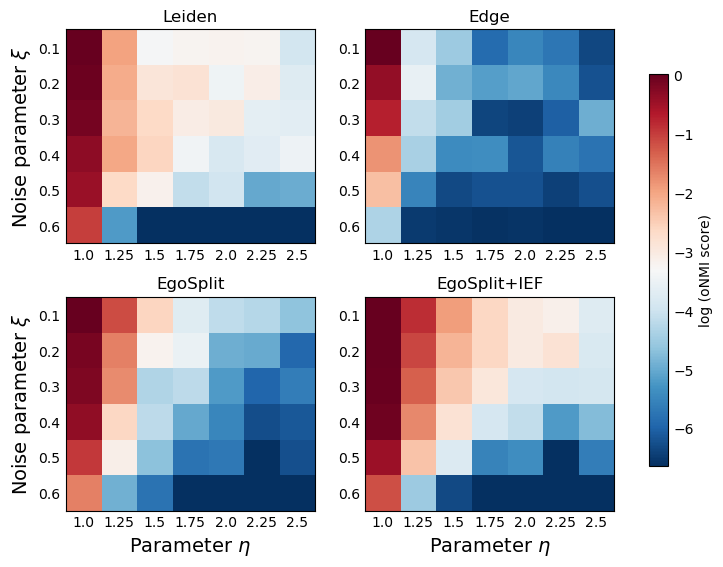

In [22]:
## image plot
plt.style.use('_mpl-gallery-nogrid')

# make data
X = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
Y = [1.0,1.25,1.5,1.75,2.0,2.25,2.5]
Scores = []
Cases = ['Leiden', 'Edge', 'EgoSplit', 'EgoSplit+IEF']
for k in range(4):
    Z = np.zeros((len(X),len(Y)))
    score = df[Cases[k]]
    ctr = 0
    for i in range(len(X)):
        for j in range(len(Y)):
            Z[i,j] = np.log2(0.01+score[ctr])
            ctr += 1    
    Scores.append(Z)

# plot
fig, axs = plt.subplots(2, 2, figsize=(7,5))
ctr = 0
cmaps = ['RdBu_r', 'viridis']
for row in range(2):
    for col in range(2):
        ax = axs[row, col]
        pcm = ax.imshow(Scores[ctr], cmap=cmaps[0])
        ax.set_title(Cases[ctr])
        ax.set_yticks(ticks=[0,1,2,3,4,5],labels=X)
        ax.set_xticks(ticks=[0,1,2,3,4,5,6],labels=Y);
        if row==1:
            ax.set_xlabel(r'Parameter $\eta$', fontsize=14)
        if col==0:
            ax.set_ylabel(r'Noise parameter $\xi$', fontsize=14)
        ctr += 1
fig.colorbar(pcm, ax=axs[:, :], shrink=0.8, label='log (oNMI score)');


In [23]:
exiting

NameError: name 'exiting' is not defined

In [ ]:
plt.figure(figsize=(6,6))

plt.subplot(221)
score = df['Leiden']
ctr = 0
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i,j] = np.log(.01+score[ctr])
        ctr += 1
plt.imshow(Z)
plt.title('Leiden')
plt.yticks(ticks=[0,1,2,3,4,5],labels=X)
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=Y);
plt.ylabel(r'Noise parameter $\xi$', fontsize=14)

plt.subplot(222)
score = df['Edge']
ctr = 0
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i,j] = np.log(.01+score[ctr])
        ctr += 1
plt.imshow(Z)
plt.title('Edge clusteirng')
plt.yticks(ticks=[0,1,2,3,4,5],labels=X)
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=Y);

plt.subplot(223)
score = df['EgoSplit']
ctr = 0
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i,j] = np.log(.01+score[ctr])
        ctr += 1
plt.imshow(Z)
plt.title('EgoSplit')
plt.yticks(ticks=[0,1,2,3,4,5],labels=X)
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=Y);
plt.xlabel(r'Parameter $\eta$', fontsize=14)
plt.ylabel(r'Noise parameter $\xi$', fontsize=14)

plt.subplot(224)
score = df['EgoSplit+IEF']
ctr = 0
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i,j] = np.log(.01+score[ctr])
        ctr += 1
im = plt.imshow(Z)
plt.title('EgoSplit+IEF')
plt.yticks(ticks=[0,1,2,3,4,5],labels=X)
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=Y);
plt.xlabel(r'Parameter $\eta$', fontsize=14);

cbar = plt.colorbar(im)
cbar.set_label("Colorbar")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

a = 2
b = 2
fig, axs = plt.subplots(a, b , figsize=(8.27, 9.69),
                        constrained_layout=True, sharey=True,
                        sharex=True)
cm = ['viridis']

ctr = 0
for col in range(b):
    for row in range(a):
        data = Scores[ctr]
        ctr += 1
        ax = axs[row, col]
        if col == 0:
            ax.set_ylabel('YYYY', fontsize=13)
        pcm = ax.imshow(data,  norm=mpl.colors.LogNorm(vmin=0.001, vmax=1),
                        cmap=cm[0],interpolation='none',
                        extent=[-17.5,17.5,-17.5,17.5])
        if row == 2:
            ax.set_xlabel('XXX',  fontsize=13)


cb1 = fig.colorbar(pcm, ax=axs[:, :2], location='top', shrink=0.6)

plt.show()

In [ ]:
df[df.xi==.15].plot(x='eta',y=['CPM', 'Edge', 'Leiden', 'EgoSplit', 'EgoSplit+CAS'], kind='bar', figsize=(8,6));


In [ ]:
df[df.eta==2.0].plot(x='xi',y=['CPM', 'Edge', 'Leiden', 'EgoSplit', 'EgoSplit+CAS'], kind='bar', figsize=(8,6));


## Testing ES+AOC and IKC+AOC


### read ABCDoo, run Leiden, ES and Beta

In [ ]:
len([j for i in LEI for j in i])

In [ ]:
Results = []
rep = 3
xi = 0.35
for eta in [1.0,1.5,2.0,2.5,3.0]:
#for eta in [1.5]:

    fn = '~/Betastar/CommunityAssociationStrength/Datasets/ABCDoo/networkfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'

    ## read graph, compute Leiden
    G = readGraph(xi=xi, eta=eta, rep=rep)
    G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
    G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
    GT = mems2comms(G.vs['comms'])[1:]  ## ignore "outlier community"
    GT = [[str(i) for i in x] for x in GT]

    ## ego-split
    comms_es = EgoSplit(G, split='CC', algo='ECG')
    ES = [list(x) for x in comms_es if len(x)>=10]
    print('Ego:',compute_oNMI( ES, GT ))
    LEI = mems2comms([[c] for c in G.vs['leiden']])
    print('Leiden:',compute_oNMI(GT, LEI))

    ## ego+beta
    C = sparse.csc_matrix((G.vcount(),len(ES)))
    C.indices = np.array([int(i) for j in ES for i in j])
    C.data = np.repeat(1,len(C.indices))
    ptr = [0]
    ctr = 0
    for x in ES:
        ctr += len(x)
        ptr.append(ctr)
    C.indptr = np.array(ptr)
    M = C.tocsr()
    ## Beta
    IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M)
    EB = []
    th = 0.1
    for i in range(Beta.shape[1]):
        x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th))[0]
        if len(x)>0:
            EB.append(list(x))        
    print('Ego+beta:',compute_oNMI(GT, EB))

    ## Leiden+beta
    C = sparse.csc_matrix((G.vcount(),len(LEI)))
    C.indices = np.array([int(i) for j in LEI for i in j])
    C.data = np.repeat(1,len(C.indices))
    ptr = [0]
    ctr = 0
    for x in LEI:
        ctr += len(x)
        ptr.append(ctr)
    C.indptr = np.array(ptr)
    M = C.tocsr()
    ## Beta
    IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M)
    LB = []
    th = 0.1
    for i in range(Beta.shape[1]):
        x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th))[0]
        if len(x)>0:
            LB.append(list(x))        
    print('Leiden+beta:',compute_oNMI(GT, LB))
    
    ## store leiden clusters
    L = []
    for v in G.vs:
        L.append( (v['leiden'],str(int(v['name'])+1)) ) ## 1-based in edge file
    with open('_clusters.txt', 'w') as fp:
        fp.write('\n'.join('%s %s' % x for x in L))
        fp.write('\n')
    
    ## Leiden + AOC    
    cmd = 'python3 ~/Betastar/aocv2_plus/v2_revisions/aoc.py -g '+fn+' -c _clusters.txt --inclusion-criterion mcd > _aoc.txt'
    os.system('source activate complexnetworks && '+cmd)
    LA = []
    df = pd.read_csv('_aoc.txt', sep=' ', header=None, names=['comm','node'])
    for i in range(max(df.comm)+1):
        LA.append([str(v-1) for v in df[df.comm==i].node]) ## back to 0-based
    print('Leiden+AOC:',compute_oNMI(LA,GT))
    
    ## store ES clusters
    L = []
    for i in range(len(ES)):
        for j in ES[i]:
            L.append( (str(i),str(int(j)+1)) )
    with open('_clusters.txt', 'w') as fp:
        fp.write('\n'.join('%s %s' % x for x in L))
        fp.write('\n')
        
    ## ES + AOC    
    cmd = 'python3 ~/Betastar/aocv2_plus/v2_revisions/aoc.py -g '+fn+' -c _clusters.txt --inclusion-criterion mcd > _aoc.txt'
    os.system('source activate complexnetworks && '+cmd)
    EA = []
    df = pd.read_csv('_aoc.txt', sep=' ', header=None, names=['comm','node'])
    for i in range(max(df.comm)+1):
        EA.append([str(v-1) for v in df[df.comm==i].node]) ## back to 0-based
    print('ES+AOC:',compute_oNMI(EA,GT))
    
    X = [eta,compute_oNMI( ES, GT ), compute_oNMI(GT, LEI), compute_oNMI(GT, EB), compute_oNMI(GT, LB),
         compute_oNMI(LA,GT),compute_oNMI(EA,GT)]
    Results.append(X)

In [ ]:
_df = pd.DataFrame(Results, columns=['eta','Ego-Split','Leiden','Ego+Beta','Leiden+Beta','Leiden+AOC','Ego+AOC'])
with open('algo_compare_aoc.pkl','wb') as fp:
    pickle.dump(_df,fp)    

In [ ]:
_df

### run IKC

In [ ]:
cmd = 'python3 /Users/francois/Betastar/ERNIE_Plus/Illinois/clustering/eleanor/code/IKC.py -o _ikc -k 10 -e '+fn
os.system('source activate complexnetworks && '+cmd)
## IKC fails - single community with 3103 nodes
df = pd.read_csv('_ikc', header=None, names=['node','comm','k','q'])
Counter(df[df.k>0].comm)
